In [0]:
import gc
import matplotlib
import numpy as np
import pandas as pd
import pickle
import sklearn
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import ParameterGrid
from numpy.random import shuffle
import os
import uuid
from google.colab import drive
import matplotlib.pyplot as plt
import keras

Using TensorFlow backend.


In [0]:
#print out memory usage
import sys

# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Get a sorted list of the objects and their sizes
sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)

[('PCA', 904),
 ('ParameterGrid', 904),
 ('RandomizedSearchCV', 904),
 ('StandardScaler', 904),
 ('find_op_params', 120),
 ('mean_squared_error', 120),
 ('r2_score', 120),
 ('shuffle', 72),
 ('drive', 56),
 ('np', 56),
 ('pd', 56),
 ('plt', 56),
 ('tf', 56)]

##Get Data Together

In [0]:
all_data = pd.read_csv('expression_sensitivity.csv')

In [0]:
all_data.set_index(all_data.iloc[:,0],inplace=True) 
all_data = all_data.iloc[:,1:]

In [0]:
n_feats = 22843
exp = all_data.iloc[:,0:n_feats]
drugs_to_pred = ['Trametinib (GSK1120212)','Selumetinib (AZD6244)','Tivozanib (AV-951)','KI20227','Dasatinib']
y = all_data[drugs_to_pred]
all_ = pd.concat([exp,y],axis=1)

In [0]:
all_.dropna(inplace=True)
data = all_.values

# all_data.fillna(all_data.mean(),inplace=True)
# data=all_data.values

In [0]:
X = data[:,0:n_feats]
X = StandardScaler().fit_transform(X)
y = data[:,n_feats:]

In [0]:
del all_data
gc.collect()

39

## Model

In [0]:
def model_predict_gen(x_train, n_lay, n_nodes, activation_func, n_output, reg_rate, dr_rate):
    layers = []
    for i in range(0, n_lay-1):
      new_layer = tf.layers.Dense(units=n_nodes, activation=activation_func,kernel_regularizer=keras.regularizers.l2(reg_rate))
      layers.append(new_layer)
    layers.append(tf.layers.Dense(units=n_output)) #should last activation func b dif?
    
    r = layers[0](x_train)
    d = tf.layers.dropout(r, rate = dr_rate)

    for i in range(1, n_lay):
        r = layers[i](d)
        d = tf.layers.dropout(r, rate = dr_rate)
    predictions_train = d
    return layers, predictions_train

In [0]:
def test_train_split(X,y,n_test):
    order = np.random.permutation(X.shape[0])
    feats_test = X[order[0:n_test],:] #90x22843
    outs_test = y[order[0:n_test]]
#     outs_test = data[order[0:n_test],n_feats:] #90x122
    feats_train = X[order[n_test:],:] #361z22843
    outs_train = y[order[n_test:]]
#     outs_train = data[order[n_test:],n_feats:] #361x122

    return feats_train, outs_train, feats_test, outs_test #np.asmatrix(outs_test).T if only one pred

In [0]:
def nn(X, y, n_val, n_ep, n_layers, n_nodes, activation_func, dr_rate, l_rate, reg_rate, n_output):
    
    validation = np.zeros(n_val)
    losses_train = []
    losses_test = []

    tf.reset_default_graph()
    n = X.shape[0]
    n_test = np.round(0.2 * n).astype('int64')
    n_epochs = n_ep
    
    for p in range(len(validation)):
        
        feats_train, outs_train, feats_test, outs_test = test_train_split(X,y,n_test)

        #prepare training Dataset
        training = tf.data.Dataset.from_tensor_slices((feats_train, outs_train))
        training = training.repeat(n_epochs).batch(n-n_test)
        iterator_train = training.make_one_shot_iterator()
        
        #prepare testing Dataset
        testing = tf.data.Dataset.from_tensor_slices((feats_test, outs_test))
        testing = testing.repeat(n_epochs).batch(n_test)
        iterator_test = testing.make_one_shot_iterator()
        
        #pull samples
        x_train, y_train = iterator_train.get_next()

        #predict
        keep_prob = tf.placeholder(tf.float32, shape=None, name='keep_prob')
        layers,y_train_pred = model_predict_gen(x_train, n_layers, n_nodes, activation_func, n_output, reg_rate, keep_prob)
        del x_train
        
        # optimizer
        tf_learning_rate = tf.placeholder(tf.float32, shape=None, name='learning_rate')
        loss_train = tf.losses.mean_squared_error(labels=y_train, predictions=y_train_pred) # pass the second value from iter.get_net() as label
#         loss_train = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_train, logits=y_train_pred)
        l2_loss = tf.losses.get_regularization_loss()
        loss_train += tf.cast(l2_loss,tf.float32)
        train_op = tf.train.AdamOptimizer(tf_learning_rate).minimize(loss_train)
        
        #testing
        x_test, y_test = iterator_test.get_next()
        
        r = layers[0](x_test)
        for i in range(1,n_layers):
            r = layers[i](r)
        y_test_pred = r
        
        loss_test = tf.losses.mean_squared_error(labels=y_test, predictions=y_test_pred)
        del layers, x_test
        
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            for i in range(n_epochs):
              _, _loss_train, _loss_test, _y_train_pred, _y_train, _y_test_pred, _y_test= \
                    sess.run((train_op, loss_train, loss_test,y_train_pred,y_train,y_test_pred,y_test), feed_dict={tf_learning_rate: l_rate, keep_prob: dr_rate})

              r2 = r2_score(y_true=_y_train, y_pred=_y_train_pred)
              r2_test = r2_score(y_true=_y_test, y_pred=_y_test_pred)
              losses_train.append(_loss_train)
              losses_test.append(_loss_test)

            validation[p] = _loss_test
        print('r2: {0}, r2_test: {1}, validation: {2}'.format(r2,r2_test, np.mean(validation)))
        res = [r2, r2_test, losses_train, _y_train_pred, _y_train, losses_test, _y_test_pred, _y_test, validation]
    return res


# Training and Optimization

In [0]:
#example run with rand params
n_nodes = 100
n_layers = 10
l_rate = 0.5
n_output = 5
reg_rate = 0.001
activation_func = tf.tanh
dr_rate = 0.1 #prob that given node will be dropped out
# n_output=data.shape[1]-n_feats #122

n_feats = 22843

res = nn(X, y, n_val = 15, n_ep = 100, n_layers, n_nodes, activation_func, dr_rate, l_rate, reg_rate, n_output)
r2, r2test, losses_train, _predictions_train, _sensitivity_train, losses_test, _predictions_test, _sensitivity_test, validation = res

### Hyperparameter tuning through randomized search

In [0]:
param_dist = {
    "n_layers" : [3,5,6,7],
    "n_nodes" : [50,100],
    "activation_func" : [tf.tanh,tf.nn.relu,tf.sigmoid],
    "dr_rate" : [0.4,0.5,0.6],
    "l_rate" : [1e-5,1e-3,0.5],
    "reg_rate" : [0.001,1e-4,0.01]
    "n_output" : [1]
}

In [0]:
def find_op_params(param_dist, perc):
  param_grid = list(ParameterGrid(param_dist))
  shuffle(param_grid)
  
  results = []
  for i in range(0,int(len(param_grid)*perc)):
      results.append(nn(X,y,**param_grid[i]))
      print('Params: {0}\nAmount complete: {1:.3f}\n'.format(param_grid[i],i/(len(param_grid)*0.4)))

  r2s_train = [r2 for r2,_, _, _, _, _, _, _, _ in results]
  r2s_test = [r2t for _,r2t, _, _, _, _, _, _, _ in results]

  best_train_params = param_grid[r2s_train.index(max(r2s_train))]
  best_test_params = param_grid[r2s_test.index(max(r2s_test))]
  print('Best Train R2: {0} \nBest Test R2: {1}'.format(max(r2s_train),max(r2s_test)))
  print('Best Train Params: {0} \nBest Test Params: {1}'.format(best_train_params,best_test_params))
  
  op_res1 = nn(X,y,**best_train_params)
  op_res2 = nn(X,y,**best_test_params)
    
  return op_res1, op_res2, best_train_params, best_test_params, r2s_train, r2s_test

In [0]:
with open('model_results_optimized6.pkl', 'wb') as f:
    pickle.dump([param_grid,results5],f,protocol=2)

In [0]:
r2, r2test, losses_train, _y_train_pred, _y_train, losses_test, _y_test_pred, _y_test, validation = find_op_params(param_grid)[0]

Best Train R2: 0.998054374605 
Best Test R2: 0.0667301768907
Best Train Params: {'dr_rate': 0.6, 'n_nodes': 100, 'l_rate': 0.001, 'activation_func': <function relu at 0x7f0ffe8ef7d0>, 'n_layers': 7, 'n_output': 1} 
Best Test Params: {'dr_rate': 0.6, 'n_nodes': 100, 'l_rate': 0.9, 'activation_func': <function sigmoid at 0x7f0ffe899398>, 'n_layers': 3, 'n_output': 1}


## Predicting Specific Drugs

In [0]:
param_dist = {
    "n_layers" : [3,5,6,7],
    "n_nodes" : [50,100],
    "activation_func" : [tf.tanh,tf.nn.relu,tf.sigmoid],
    "dr_rate" : [0.4,0.5,0.6],
    "l_rate" : [1e-5,1e-3,0.3],
    "reg_rate" : [0.001,1e-4,0.01],
    "n_output" : [5]
}

In [0]:
res = find_op_params(param_dist, 0.3)


In [0]:
r2, r2test, losses_train, _y_train_pred, _y_train, losses_test, _y_test_pred, _y_test, validation = op_res2

In [0]:
res = find_op_params(param_dist, 0.3)

## Op Model

In [0]:
params = {'dr_rate': 0.5, 'n_nodes': 100, 'l_rate': 0.001, 'activation_func': tf.nn.relu, 'n_layers': 3, 'reg_rate': 0.001, 'n_output': 5}

res = nn(X, y, n_val = 15, n_ep = 300, **params)
r2, r2test, losses_train, _predictions_train, _sensitivity_train, losses_test, _predictions_test, _sensitivity_test, validation = res

In [0]:
results5 = []
for i in range(0,int(len(param_grid)*0.4)):
    results5.append(nn(X,y,**param_grid[i]))
    print('Params: {0}\nAmount complete: {1:.3f}\n'.format(param_grid[i],i/(len(param_grid)*0.4)))

# Visualizing Results

In [0]:
with open('model_results.pkl', 'rb') as f:  # Python 3: open(..., 'rb')
    a = pickle.load(f)

In [0]:
y_train = pd.DataFrame(_sensitivity_train)
y_pred = pd.DataFrame(_predictions_train)
plt.plot(y_train.iloc[:,0],y_pred.iloc[:,0],'bo')
plt.xlabel('y train')
plt.ylabel('y pred')
plt.title('Pred vs Train - top 5 drugs')

#Best Train Params: {'dr_rate': 0.3, 'n_nodes': 100, 'l_rate': 0.5, 'activation_func': <function sigmoid at 0x7fcd3011b6e0>, 'n_layers': 3, 'n_output': 1} 
#Best Train R2: 0.942072275879 


In [0]:
y_test = pd.DataFrame(_sensitivity_test)
y_pred = pd.DataFrame(_predictions_test)
plt.plot(y_test.iloc[:,0],y_pred.iloc[:,0],'bo')
plt.xlabel('y test')
plt.ylabel('y pred')
plt.title('Pred vs Test - top 5 drugs')
#Best Train Params: {'dr_rate': 0.3, 'n_nodes': 100, 'l_rate': 0.5, 'activation_func': <function sigmoid at 0x7fcd3011b6e0>, 'n_layers': 3, 'n_output': 1} 
#Best Train R2: 0.942072275879 

#but testing data is shit

(array([ 1.,  4.,  4.,  5.,  8., 49.,  9.,  4.,  4.,  2.]),
 array([ 40.95848727,  61.49569792,  82.03290858, 102.57011924,
        123.10732989, 143.64454055, 164.1817512 , 184.71896186,
        205.25617252, 225.79338317, 246.33059383]),
 <a list of 10 Patch objects>)

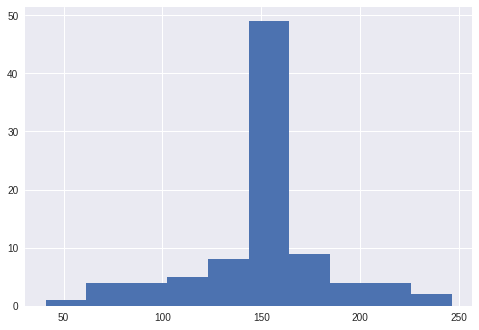

In [0]:
plt.hist(y_test.iloc[:,0])

Text(0.5,1,'Train and Test Values')

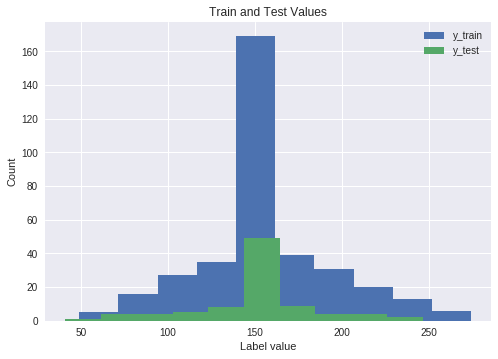

In [0]:
plt.hist(_y_train, label='y_train')
plt.hist(_y_test, label = 'y_test')
plt.xlabel('Label value')
plt.ylabel('Count')
plt.legend()
plt.title('Train and Test Values')

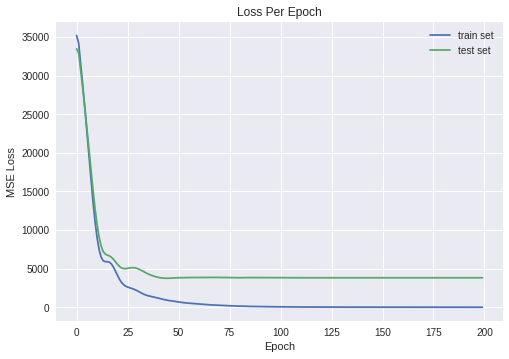

In [0]:
#plot test/trainig error
plt.plot(losses_train[0:len(losses_train)/15], label = 'train set')
plt.plot(losses_test[0:len(losses_train)/15], label = 'test set')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Loss Per Epoch')
plt.show()